# Project 3: Credit Card Default Detection

#### 1. Given the data below, please classify the two cluster data and find the boundary line to devide the two groups. Use visualization to show your answer. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn import datasets

X,Y = datasets.make_blobs(n_samples=200, n_features=2, centers=2, random_state=2)

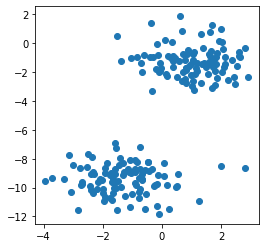

In [2]:
plt.figure(figsize=(4, 4))
plt.scatter(X[:, 0], X[:, 1])
plt.show()

#### 2. Following you will need to solve a Credit Card Default Detection Case

* Credit Card Default
    * To default is to fail to make a payment on a debt by the due date. If this happens with a credit card, creditors might raise interest rates to the default (or penalty rate) or decrease the line of credit. In case of serious delinquency, the card issuer can even take legal action to enforce payment or to garnish wages.

* Objective
    * Our objective for this project is, given the data set, we are going to build a machine learning model to predict whether a credit card is going to default

**Data Description:**

**id**: A unique Id field which represents a customer

**X1**: Credit line

**X2**: Gender (1 = male; 2 = female).

**X3**: Education (1 = graduate school; 2 = university; 3 = high school; 4 = others).

**X4**: Marital status (1 = married; 2 = single; 3 = others).

**X5**: Age (year).

**X6 - X11**: History of past payment. 

**X6** = September, 2015;

**X7** = August, 2015;

**X11** =April, 2015. -1 = pay one month ahead; -2 = pay two month ahead; 0 = pay on time; Positive means the payment delayed months, 1 = delay 1 month, 2 = delay 2 months, etc.

**X12- X17**: Amount in bill statement.

**X12** = amount of bill statementSeptember, 2015

**X13** = amount of bill statementAugust, 2015

**X17** = amount of bill statementApril, 2015. 

**X18-X23**: Amount of previous payment

**X18** = amount paid in September, 2015; 

**X19** = amount paid in August, 2015; 

**X23** = amount paid in April, 2015.

**Y**: A binary response variable to indicate whether the credit card is default (1) or not (0).

This is a real problem to classify multi-feature data into two groups.




# Objective
* In this project, we are going to predict whether a credit card would be default or not. It's a classification problem where the label set is imbalanced since most of the credit cards are normal and only a few of them are default. For this project, we can not only have the chance to train a powerful classification model, but also tackle on the very important problem we might encounter in the future.

## Steps:
1. Perform feature engineering to the dataset the way you see fit.
2. Choose a classifier you like to make prediction
3. Keep in mind that the labels in target variable is imbalanced and figure out a way to deal with that problem

**Hint for steps**
1.	Load data
2.	There are so many features, please discern the categorical and continuous variables.
3.	Check if features have linear relationship between each other.
5.	Choose the proper method to train the model:
6.	Evaluate your model. 
7.	Use your model to train the data. And make your submission file.

**Step 1. Load Data**

In [3]:
raw = pd.read_csv('raw_data.csv')
print('raw.shape = ' + str(raw.shape))
raw.head(5)

raw.shape = (25000, 25)


,id,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X15,X16,X17,X18,X19,X20,X21,X22,X23,Y
0,1,200000,2,3,1,53,0,0,0,0,...,133207,136159,138741,6500,5000,5000,5100,5000,5400,0
1,2,130000,2,3,2,39,0,0,0,2,...,130814,130758,123468,7500,10000,0,4500,4500,4179,0
2,3,350000,2,1,2,41,0,0,0,0,...,119947,117328,118400,6000,5900,5800,4100,4500,5000,0
3,4,240000,2,2,1,43,1,-2,-2,-1,...,12700,12500,26225,0,0,12700,0,13725,0,0
4,5,180000,1,2,2,28,-1,-1,-1,-1,...,332,416,416,0,416,332,500,3500,832,0


**Step 2. Decern Categorical and Quantitative Variables**

In [4]:
categorical_columns = []
categorical_columns.extend(['X2', 'X3', 'X4'])  # gender, education level, marital status are categorical
categorical_columns.extend(['X%d' % x for x in range(6, 12)])  # payment ahead has non-linear effect on its scale
print('#categorical_columns = %d' % len(categorical_columns))

#categorical_columns = 9


In [5]:
quantitative_columns = [x for x in raw.columns if (x not in categorical_columns) and (x not in ('id', 'Y'))]
print('#quantitative_columns = %d' % len(quantitative_columns))

#quantitative_columns = 14


**Step 3. Data Cleaning**

In [6]:
columns_to_drop = []  # list of columns to drop in the final step
to_join = pd.DataFrame(data=raw[['id']], index=raw.index)  # dataframe to be joined in the final step

*3.1 Missing Value Check*

In [7]:
number_missing = raw.isna().sum().reset_index()
number_missing.columns = ['feature', 'number_missing']
number_missing.sort_values(by='number_missing', ascending=False, inplace=True)
number_missing.number_missing.max()

0

*3.2 Linearity Check*

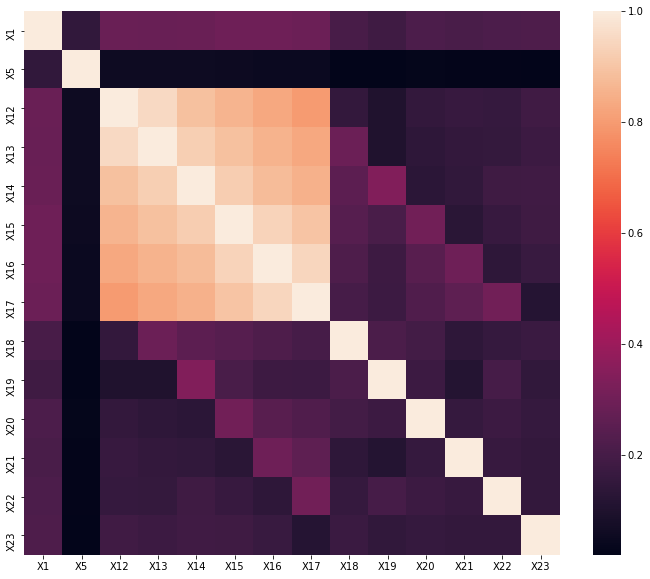

In [8]:
corr = raw.loc[:, quantitative_columns].corr()
plt.figure(figsize = (12, 10))
sns.heatmap(corr)
plt.show()

No missing values - so use average of X12 ~ X17 instead of them.

In [9]:
c = ['X%d' % x for x in range(12, 18)]  # the columns [X12 ~ X17]
columns_to_drop.extend(c)
to_join['mean_bill_statement'] = raw[c].mean(axis = 1)

*3.3 Serialize Categorical Features*

In [10]:
columns_to_drop.append('X3')  # X3: Education (1 = graduate school; 2 = university; 3 = high school; 4 = others).
for i in (1, 2, 3):
    to_join['education_%d' % i] = (raw['X3'] == i).astype(float)

In [11]:
columns_to_drop.append('X4')  # X4: Marital status (1 = married; 2 = single; 3 = others).
for i in (1, 2):
    to_join['maritial_%d' % i] = (raw['X4'] == i).astype(float)

*3.4 Build Training Set*

In [12]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(
    raw.drop(columns_to_drop, axis=1).merge(to_join, on='id', sort=False).drop('id', axis=1),
    test_size=0.2, random_state=1,
    stratify=raw['Y'],
)

**4. Method Selection**

In [13]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
scoring = ['accuracy', 'balanced_accuracy', 'f1', 'f1_weighted']

*4.1 Logistic Learning*

In [14]:
from sklearn.linear_model import LogisticRegression
pipe_lr = Pipeline([
    ('sc', StandardScaler()),
    ('lr', LogisticRegression(random_state=1)),
])
scores_lr = cross_validate(
    estimator=pipe_lr,
    X=df_train.drop('Y', axis=1), y=df_train['Y'],
    scoring=scoring,
    cv=10, n_jobs=-1
)
print('Logistic Regression:')
for s in scoring:
    print('  %.3f +/- %.3f in %s' % (np.mean(scores_lr['test_' + s]), np.std(scores_lr['test_' + s]), s))

Logistic Regression:
  0.810 +/- 0.004 in accuracy
  0.605 +/- 0.006 in balanced_accuracy
  0.356 +/- 0.014 in f1
  0.770 +/- 0.005 in f1_weighted


*4.2 Logistic Regression with Balanced Labels*

In [15]:
y_counts = df_train['Y'].value_counts()
y_counts

0    15562
1     4438
Name: Y, dtype: int64

In [16]:
resampled = df_train.loc[df_train['Y'] == 1].sample(y_counts[0] - y_counts[1], replace=True, random_state=1)
balanced_train = pd.concat([df_train, resampled])
balanced_train['Y'].value_counts()

1    15562
0    15562
Name: Y, dtype: int64

With this balanced dataset, redo the LogReg.

In [17]:
from sklearn.linear_model import LogisticRegression
pipe_lr = Pipeline([
    ('sc', StandardScaler()),
    ('lr', LogisticRegression(random_state=1)),
])
scores_lr = cross_validate(
    estimator=pipe_lr,
    X=balanced_train.drop('Y', axis=1), y=balanced_train['Y'],
    scoring=scoring,
    cv=10, n_jobs=-1
)
print('Logistic Regression:')
for s in scoring:
    print('  %.3f +/- %.3f in %s' % (np.mean(scores_lr['test_' + s]), np.std(scores_lr['test_' + s]), s))

Logistic Regression:
  0.678 +/- 0.010 in accuracy
  0.678 +/- 0.010 in balanced_accuracy
  0.671 +/- 0.012 in f1
  0.678 +/- 0.010 in f1_weighted


*4.3 Random Forest*

In [18]:
from sklearn.ensemble import RandomForestClassifier
pipe_rf = Pipeline([
    ('sc', StandardScaler()),
    ('rf', RandomForestClassifier(n_estimators=100, max_features=6, random_state=1)),
])
scores_rf = cross_validate(
    estimator=pipe_rf,
    X=balanced_train.drop('Y', axis=1), y=balanced_train['Y'],
    scoring=scoring,
    cv=10, n_jobs=-1
)
print('Random Forest:')
for s in scoring:
    print('  %.3f +/- %.3f in %s' % (np.mean(scores_rf['test_' + s]), np.std(scores_rf['test_' + s]), s))

Random Forest:
  0.948 +/- 0.010 in accuracy
  0.948 +/- 0.010 in balanced_accuracy
  0.950 +/- 0.010 in f1
  0.948 +/- 0.010 in f1_weighted


**5. Evaluate Your Model**

Ramdom Forest has better performance on the training set, thus chosen.

In [19]:
pipe_rf.fit(X=balanced_train.drop('Y', axis=1), y=balanced_train['Y'])

Pipeline(steps=[('sc', StandardScaler()),
                ('rf', RandomForestClassifier(max_features=6, random_state=1))])

In [20]:
from sklearn.metrics import get_scorer
for s in scoring:
    print('%.3f on test in %s' % (get_scorer(s)(estimator=pipe_rf, X=df_test.drop('Y', axis=1) ,y_true=df_test['Y']), s))

0.807 on test in accuracy
0.668 on test in balanced_accuracy
0.490 on test in f1
0.794 on test in f1_weighted


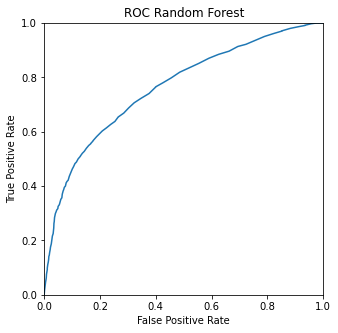

In [21]:
from sklearn.metrics import roc_curve
proba_binary = pipe_rf.predict_proba(df_test.drop('Y', axis=1))[:, 1]
fpr, tpr, _ = roc_curve(y_true=df_test['Y'], y_score=proba_binary)
plt.figure(figsize=(5, 5)); plt.title('ROC Random Forest')
plt.xlim(0, 1); plt.xlabel('False Positive Rate')
plt.ylim(0, 1); plt.ylabel('True Positive Rate')
plt.plot(fpr, tpr)
plt.show()